In [2]:
from src.annotator import Annotator
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
def get_row_pair_A(pair, pair_prime):
    x, y = pair[0], pair[1]
    x_p, y_p = pair_prime[0], pair_prime[1]
    return [
        [0, 0, 0, -x, -y, -1, y_p*x, y_p*y, y_p],
        [x, y, 1, 0, 0, 0, -x_p*x, -x_p*y, -x_p]
    ]

def build_A(pairs, pairs_prime):
    A = np.zeros((pairs.shape[0] * 2, 9))
    for i, (p, p_prime) in enumerate(zip(pairs, pairs_prime)):
        A[ i*2 : (i+1)*2 ] = get_row_pair_A(p, p_prime)
    
    return A

def get_homography_matrix(pairs, pairs_prime):
    A = build_A(pairs, pairs_prime)
    _, _, v = np.linalg.svd(A)
    H = (v[-1] / v[-1, -1]).reshape(3, 3)
    return H

## 1. Load manual annotations and images

In [12]:
ann = Annotator('images/boat/img1.pgm', 'images/boat/img2.pgm', annotation_mode = False)
p = np.array(ann.coords)
points, points_prime = p[0], p[1]
print(points.shape, points_prime.shape)

Loading Annotator in data load mode...
Image Files:
> images/boat/img1.pgm
> images/boat/img2.pgm
Searching for annotation file: img1_img2_annotation.txt
> Annotation file found.
(12, 2) (12, 2)


## 2. Detect sift features for both images

In [30]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()
points, descriptors_image = sift.detectAndCompute(ann.images[0] ,None)
points_prime, descriptors_rotated_image = sift.detectAndCompute(ann.images[1], None)
points = np.array([kp.pt for kp in points]).astype(np.uint)
points_prime = np.array([kp.pt for kp in points_prime]).astype(np.uint)
print(points.shape, points_prime.shape)

(8850, 2) (8548, 2)


## 3. Use kNN matching (with k=2 neighbors) 

Also applies ratio test. Meaning if ratio of closest point to second closest is less than 0.8 (from the sift paper) then discard the match.
This supposedly discards 90% of false matches while discarding only 5% of true matches (according to sift paper)
Also selects a random subset of the resulting matches

In [31]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_image, descriptors_rotated_image, k=2)

good = np.array([
    [m.trainIdx, m.queryIdx] 
    for m,n in matches 
    if m.distance < 0.8 * n.distance
])

points = points[good[:, 1]]
points_prime_matched = points_prime[good[:, 0]]

randints = np.random.randint(0, high=len(points), size=10)
points = points[randints].astype(int)
points_prime_matched = points_prime_matched[randints].astype(int)

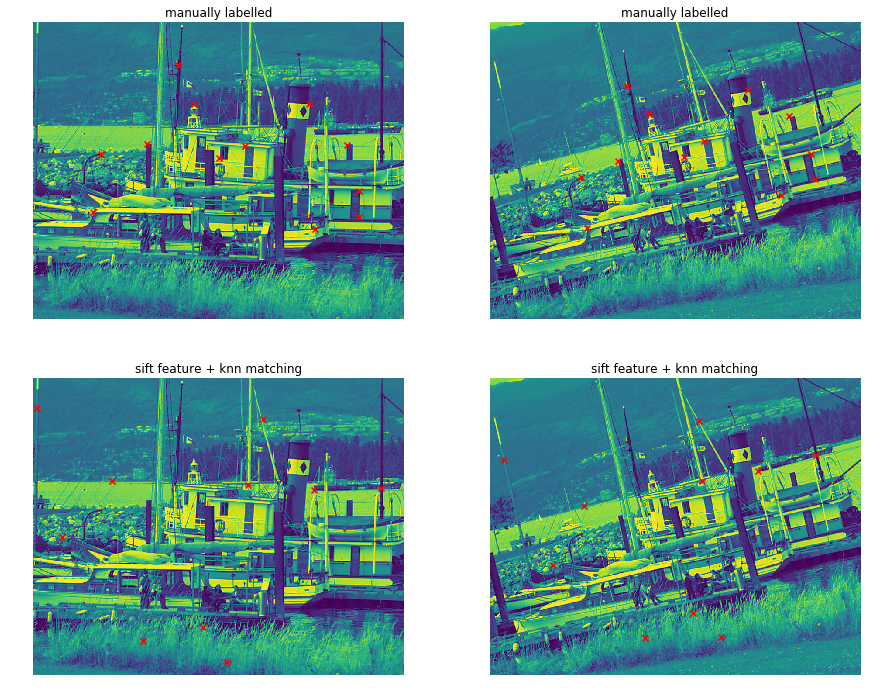

In [32]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.imshow(ann.images[0])
plt.scatter(p[0, :, 0], p[0, :, 1], marker='x', c='r')
plt.axis('off')
plt.title('manually labelled')

plt.subplot(2, 2, 2)
plt.imshow(ann.images[1])
plt.scatter(p[1, :, 0], p[1, :, 1], marker='x', c='r')
plt.axis('off')
plt.title('manually labelled')

plt.subplot(2, 2, 3)
plt.imshow(ann.images[0])
plt.scatter(points[:, 0], points[:, 1], marker='x', c='r')
plt.axis('off')
plt.title('sift feature + knn matching')

plt.subplot(2, 2, 4)
plt.imshow(ann.images[1])
plt.scatter(points_prime_matched[:, 0], points_prime_matched[:, 1], marker='x', c='r')
plt.axis('off')
plt.title('sift feature + knn matching')

plt.show()

## 4. Compute Homography matrices for manually labelled (H\_ref) and sift points pairs (H)

In [33]:
H = get_homography_matrix(points, points_prime_matched)
H_ref = get_homography_matrix(p[0], p[1])
print('H:\n{}\n\nH_ref:\n{}'.format(H, H_ref))

H:
[[ 8.57618731e-01  2.15841813e-01  1.00495489e+01]
 [-2.13291537e-01  8.57645759e-01  1.31274691e+02]
 [ 1.63963387e-06  7.89431800e-07  1.00000000e+00]]

H_ref:
[[ 8.49172410e-01  2.24638493e-01  1.09888586e+01]
 [-2.16979364e-01  8.54507571e-01  1.33214378e+02]
 [-9.79383450e-06  1.12284412e-05  1.00000000e+00]]


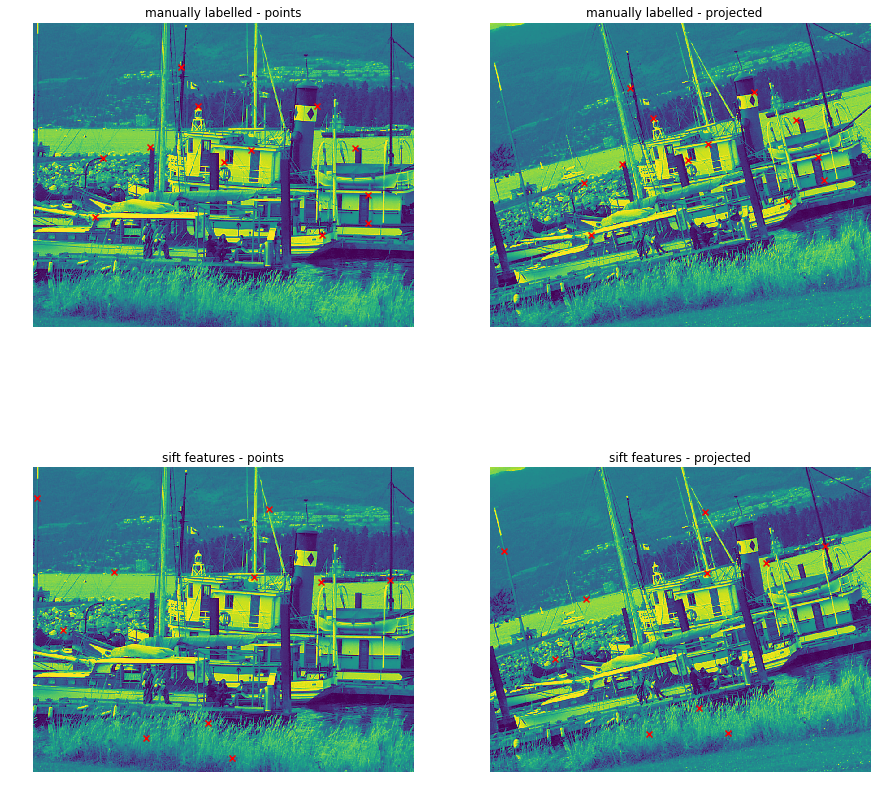

In [34]:
tmp_points = np.append(p[0], np.ones((p[0].shape[0], 1)), axis = 1)
projected_points = H_ref.dot(tmp_points.T).T

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(ann.images[0])
plt.scatter(p[0, :, 0], p[0, :, 1], marker='x', c='r')
plt.axis('off')
plt.title('manually labelled - points')

plt.subplot(2, 2, 2)
plt.imshow(ann.images[1])
plt.scatter(projected_points[:, 0], projected_points[:, 1], marker='x', c='r')
plt.axis('off')
plt.title('manually labelled - projected   ')

tmp_points = np.append(points, np.ones((points.shape[0], 1)), axis = 1)
projected_points = H.dot(tmp_points.T).T

plt.subplot(2, 2, 3)
plt.imshow(ann.images[0])
plt.scatter(points[:, 0], points[:, 1], marker='x', c='r')
plt.axis('off')
plt.title('sift features - points')

plt.subplot(2, 2, 4)
plt.imshow(ann.images[1])
plt.scatter(projected_points[:, 0], projected_points[:, 1], marker='x', c='r')
plt.axis('off')
plt.title('sift features - projected')

plt.show()

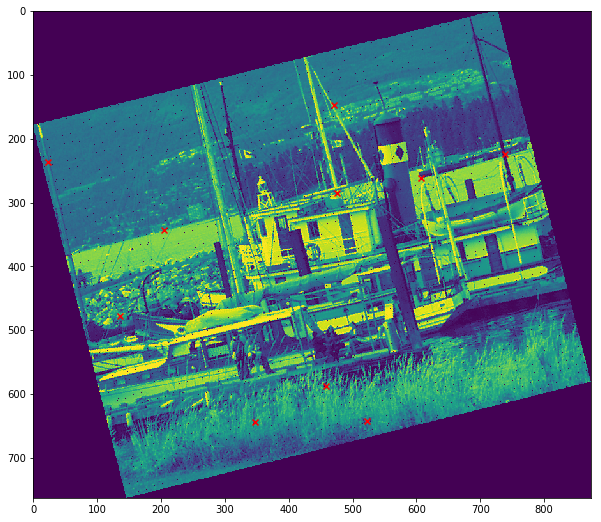

In [36]:
im = ann.images[0]
height = im.shape[0]
width = im.shape[1]

mesh = np.meshgrid(np.arange(width), np.arange(height))
coords = np.concatenate((mesh[0][..., None], mesh[1][..., None], np.ones((*im.shape, 1))), axis=2) # create 2d array of [x y 1] coordinates

projected_coords = coords.dot(H.T) # project coordinate grid onto other image
projected_coords[:, :, :2] /= projected_coords[:, :, 2:] # divide x and y coords by z coord
projected_coords = projected_coords.astype(int)

min_x, max_x = np.min(projected_coords[:, :, 0]), np.max(projected_coords[:, :, 0])
min_y, max_y = np.min(projected_coords[:, :, 1]), np.max(projected_coords[:, :, 1])

box = np.zeros((max_y - min_y + 1, max_x - min_x + 1)) # create placeholder for pixels
box[projected_coords[:, :, 1] - min_y, projected_coords[:, :, 0] - min_x] = im # set projected coordinates to pixel values of original coordinates

plt.figure(figsize=(10, 10))
plt.imshow(box)
plt.scatter(projected_points[:, 0] - min_x, projected_points[:, 1] - min_y, marker='x', c='r')
plt.show()

In [37]:
from sklearn.metrics.pairwise import euclidean_distances

homography_distance = np.linalg.norm(projected_points[:, :2] - points_prime_matched, axis = 1).mean() #mean euclidean distance between each pair of points
print('Accuracy: {}'.format(1 - homography_distance))

Accuracy: 0.15694823671692504
